## Cài đặt các thư viện cần thiết

In [ ]:
!pip install torchtext==0.6.0
!pip install spacy
!pip install https://gitlab.com/trungtv/vi_spacy/-/raw/master/vi_core_news_lg/dist/vi_core_news_lg-0.0.1.tar.gz
!pip install Pyvi
!pip install en_core_web_sm
!pip install langdetect
!pip install contractions
!pip install dill

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.6 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.2
    Uninstalling torchtext-0.15.2:
      Successfully uninstalled torchtext-0.15.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.5/254.5 MB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 64.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 659.5/659.5 kB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 10.3 MB/s eta 0:00:00
  Created wheel for vi-core-news-lg: filename=vi_core_news_lg-0.0.1-py3-none-any.whl size=254513599 sha256=c3fc92106b5d9a47206623a9d1f3947217752cd70ad3ae194ab80bb327b519f9
  Stored in directory: /root/.cache/pip/wheels/9f/44/ad/99

In [ ]:
from torchtext.data import Field, Example, Dataset, BucketIterator
import os
import langdetect
import re
import torch
import torch.optim as  optim
from torch import nn
import numpy as np
from torchtext import data
import spacy
from spacy.lang.vi import Vietnamese
import contractions
import pandas as pd
import dill

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Chuẩn bị dữ liệu

Mô hình token hóa dữ liệu tiếng Anh và tiếng Việt

In [ ]:
nlp_vi = Vietnamese()
nlp_en = spacy.load("en_core_web_sm")

def tokenize_vi(text):
    return [token.text for token in nlp_vi.tokenizer(text)]

def tokenize_en(text):
    return [token.text for token in nlp_en.tokenizer(text)]

In [ ]:
source = Field(tokenize=tokenize_en, init_token='<sos>',
               eos_token='<eos>', lower=True)
target = Field(tokenize=tokenize_vi, init_token='<sos>',
               eos_token='<eos>', lower=True)

fields = {"English": ("src", source), "Vietnamese": ("trg", target)}

Đọc và xử lý dữ liệu:
- Loại bỏ các ký tự không phải từ, xóa dấu cách dư thừa.
- Đối với tiếng Anh: Chuyển đổi các từ viết gọn (Vd: I'm -> I am, you're -> you are)

In [ ]:
!wget "https://github.com/ppl160902/statistical_learning/raw/main/dataset/english_vietnamese.csv"
df = pd.read_csv("/content/english_vietnamese.csv")

--2023-06-29 09:32:41--  https://github.com/ppl160902/statistical_learning/raw/main/dataset/english_vietnamese.csv
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ppl160902/statistical_learning/main/dataset/english_vietnamese.csv [following]
--2023-06-29 09:32:41--  https://raw.githubusercontent.com/ppl160902/statistical_learning/main/dataset/english_vietnamese.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21186474 (20M) [text/plain]
Saving to: ‘english_vietnamese.csv’

english_vietnamese. 100%[===================>]  20.20M  --.-KB/s    in 0.08s   

2023-06-29 09:32:43 (269 MB/s) - ‘englis

In [ ]:
def transform_text(text, eng=True):
    if eng:
        text = contractions.fix(text)
    s = re.sub(r'[^\w\s]', '', text)
    s = re.sub('\s+',' ',s).strip()
    return s.lower()

In [ ]:
df['english'] = df['english'].apply(transform_text)
df['vietnamese'] = df['vietnamese'].apply(transform_text, eng=False)

In [ ]:
sources = df['english'].to_list()
targets = df['vietnamese'].to_list()
examples = []
for src_sentence, trg_sentence in zip(sources, targets):
    example = Example.fromlist([src_sentence, trg_sentence], fields=[('src', source), ('trg', target)])
    examples.append(example)

Tạo dateset, gồm train data, valid data và test data

In [ ]:
# Tạo dataset từ example
dataset = Dataset(examples, fields=[('src', source), ('trg', target)])

# Chia train, valid, test
train_data, valid_data, test_data = dataset.split(split_ratio=[0.7, 0.15, 0.15])

# Xây dựng vocabulary
source.build_vocab(train_data,min_freq=2)
target.build_vocab(train_data,min_freq=2)

print(target.vocab.freqs.most_common(10))


[('tôi', 70682), ('bạn', 42068), ('tom', 38695), ('không', 35023), ('đã', 25880), ('một', 23481), ('anh', 22162), ('của', 21395), ('có', 20645), ('là', 18903)]


In [ ]:
with open("/content/source_E2V.Field","wb")as f:
     dill.dump(source,f)

with open("/content/target_E2V.Field","wb")as f:
     dill.dump(target,f)

## Thiết lập và chọn tham số mô hình

In [ ]:
BATCH_SIZE = 64

train_iterator,valid_iterator,test_iterator = data.BucketIterator.splits(
    (train_data,valid_data,test_data),
    batch_size = BATCH_SIZE,
    device = device,
    sort=False,
    sort_within_batch=False,
shuffle=True)

In [ ]:
class TranslateTransformer(nn.Module):
    def __init__(
        self,
        embedding_size,
        src_vocab_size,
        trg_vocab_size,
        src_pad_idx,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        max_len,
    ):
        super(TranslateTransformer, self).__init__()
        self.srcEmbeddings = nn.Embedding(src_vocab_size,embedding_size)
        self.trgEmbeddings= nn.Embedding(trg_vocab_size,embedding_size)
        self.srcPositionalEmbeddings= nn.Embedding(max_len,embedding_size)
        self.trgPositionalEmbeddings= nn.Embedding(max_len,embedding_size)
        self.transformer = nn.Transformer(
            embedding_size,
            num_heads,
            num_encoder_layers,
            num_decoder_layers,
        )
        self.fc_out = nn.Linear(embedding_size, trg_vocab_size)
        self.dropout = nn.Dropout(0.1)
        self.src_pad_idx = src_pad_idx
        self.max_len = max_len

    def make_src_mask(self, src):
        src_mask = src.transpose(0,1) == self.src_pad_idx

        return src_mask.to(device)

    def forward(self,x,trg):
        src_seq_length = x.shape[0]
        N = x.shape[1]
        trg_seq_length = trg.shape[0]

        src_positions = (
            torch.arange(0, src_seq_length)
            .reshape(src_seq_length,1)  + torch.zeros(src_seq_length,N)
        ).to(device)

        trg_positions = (
            torch.arange(0, trg_seq_length)
            .reshape(trg_seq_length,1)  + torch.zeros(trg_seq_length,N)
        ).to(device)


        srcWords = self.dropout(self.srcEmbeddings(x.long()) +self.srcPositionalEmbeddings(src_positions.long()))
        trgWords = self.dropout(self.trgEmbeddings(trg.long())+self.trgPositionalEmbeddings(trg_positions.long()))

        src_padding_mask = self.make_src_mask(x)
        trg_mask = self.transformer.generate_square_subsequent_mask(trg_seq_length).to(device)


        out = self.transformer(srcWords,trgWords, src_key_padding_mask=src_padding_mask,tgt_mask=trg_mask )
        out= self.fc_out(out)
        return out

In [ ]:
src_vocab_size  = len(source.vocab)
print("Size of english vocabulary:",src_vocab_size)

trg_vocab_size =len(target.vocab)
print("Size of vietnamese vocabulary:",trg_vocab_size)

num_heads = 8
num_encoder_layers = 3
num_decoder_layers = 3

max_len= 225
embedding_size= 256
src_pad_idx = source.vocab.stoi["<pad>"]

model = TranslateTransformer(
    embedding_size,
    src_vocab_size,
    trg_vocab_size,
    src_pad_idx,
    num_heads,
    num_encoder_layers,
    num_decoder_layers,
    max_len
).to(device)

Size of english vocabulary: 11800
Size of vietnamese vocabulary: 7934


In [ ]:
loss_track = []
loss_validation_track= []

In [ ]:
optimizer = optim.Adagrad(model.parameters(), lr = 0.003)
EPOCHS = 60

pad_idx = source.vocab.stoi["<pad>"]
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

for i in range(0,EPOCHS):
    stepLoss=[]
    model.train()
    for batch in train_iterator:
        input_sentence = batch.src.to(device)
        trg = batch.trg.to(device)

        optimizer.zero_grad()
        out = model(input_sentence,trg[:-1])
        out = out.reshape(-1,trg_vocab_size)
        trg = trg[1:].reshape(-1)
        loss = criterion(out,trg)

        loss.backward()
        optimizer.step()
        stepLoss.append(loss.item())


    loss_track.append(np.mean(stepLoss))
    print("train crossentropy at epoch {} loss: ".format(i),np.mean(stepLoss))

    stepValidLoss=[]
    total_correct = 0
    total_examples = 0

    model.eval()
    torch.save(model.state_dict(), 'model{:02d}.pth'.format(i+1))
    for batch  in valid_iterator:
        input_sentence = batch.src.to(device)
        trg = batch.trg.to(device)

        optimizer.zero_grad()
        out = model(input_sentence,trg[:-1])
        predictions = out.argmax(dim=-1)
        total_correct += (predictions == trg[1:]).sum().item()
        total_examples += trg[1:].numel()

        out = out.reshape(-1,trg_vocab_size)
        trg = trg[1:].reshape(-1)
        loss = criterion(out,trg)

        stepValidLoss.append(loss.item())

    loss_validation_track.append(np.mean(stepValidLoss))
    accuracy = total_correct / total_examples
    print("validation crossentropy at epoch {} loss: ".format(i),np.mean(stepValidLoss))
    print(f"Accuracy: {accuracy}")

train crossentropy at epoch 0 loss:  3.488324632061471
validation crossentropy at epoch 0 loss:  2.4650229071610728
Accuracy: 0.26742179595061555
train crossentropy at epoch 1 loss:  2.4020151919169392
validation crossentropy at epoch 1 loss:  1.9625748701943646
Accuracy: 0.2987737963897561
train crossentropy at epoch 2 loss:  2.0295405328702585
validation crossentropy at epoch 2 loss:  1.703165798779302
Accuracy: 0.31674664015470555
train crossentropy at epoch 3 loss:  1.8098431836358078
validation crossentropy at epoch 3 loss:  1.5462888559239023
Accuracy: 0.32480384824086705
train crossentropy at epoch 4 loss:  1.6584752795078772
validation crossentropy at epoch 4 loss:  1.4320979328363534
Accuracy: 0.33110450174191536
train crossentropy at epoch 5 loss:  1.5456829032023176
validation crossentropy at epoch 5 loss:  1.3413127727756564
Accuracy: 0.3388095147120633
train crossentropy at epoch 6 loss:  1.4550954814866293
validation crossentropy at epoch 6 loss:  1.2866935858990523
Accur

## Đánh giá mô hình

In [ ]:
def translate(model,sentence,srcField,targetField,srcTokenizer):
    model.eval()
    processed_sentence = srcField.process([srcTokenizer(sentence)]).to(device)
    trg = ["<sos>"]
    for iter in range(60):

        trg_indecies = [targetField.vocab.stoi[word] for word in trg]
        outputs = torch.Tensor(trg_indecies).unsqueeze(1).to(device)
        outputs = model(processed_sentence,outputs)

        if targetField.vocab.itos[outputs.argmax(2)[-1:].item()] == "<unk>":
            continue

        if targetField.vocab.itos[outputs.argmax(2)[-1:].item()] == "<eos>":
            break

        trg.append(targetField.vocab.itos[outputs.argmax(2)[-1:].item()])

    return " ".join([word for word in trg if word != "<unk>"][1:-1])

Kiểm tra độ chính xác của các mô hình

In [ ]:
model_test = TranslateTransformer(
    embedding_size,
    src_vocab_size,
    trg_vocab_size,
    src_pad_idx,
    num_heads,
    num_encoder_layers,
    num_decoder_layers,
    max_len
).to(device)

model_accuracy = []

for i in range(EPOCHS):
  model_path = '/content/model{:02d}.pth'.format(i+1)
  model_test.load_state_dict(torch.load(model_path))

  model_test.eval()
  total_correct = 0
  total_examples = 0

  for batch in test_iterator:
      input_sentence = batch.src.to(device)
      trg = batch.trg.to(device)

      with torch.no_grad():
          output = model_test(input_sentence, trg[:-1])
          predictions = output.argmax(dim=-1)

      total_correct += (predictions == trg[1:]).sum().item()
      total_examples += trg[1:].numel()

  accuracy = total_correct / total_examples
  model_accuracy.append(accuracy)
  print(f"Model {i+1}")
  print(f"Accuracy: {accuracy}")
  print("Translated: ",
        translate(model_test,transform_text('The only way to do great work is to love what you do.'), source, target, tokenize_en))
  print('=================================================================================')


Model 1
Accuracy: 0.27369255437141343
Translated:  chỉ chỉ cần phải làm những gì bạn
Model 2
Accuracy: 0.30601070635380456
Translated:  cách duy nhất để làm tốt hơn là những gì bạn
Model 3
Accuracy: 0.32272601052784083
Translated:  cách duy nhất để làm tốt hơn là yêu bạn làm
Model 4
Accuracy: 0.3315359221666346
Translated:  cách duy nhất để làm tốt hơn là yêu những gì bạn
Model 5
Accuracy: 0.3386642953440223
Translated:  cách duy nhất để làm tốt hơn là yêu những gì bạn
Model 6
Accuracy: 0.34495857184087736
Translated:  cách duy nhất để làm tốt hơn là yêu những gì bạn
Model 7
Accuracy: 0.34981766808346215
Translated:  cách duy nhất để làm tốt hơn là yêu những gì bạn
Model 8
Accuracy: 0.3540554172908713
Translated:  cách duy nhất để làm tốt hơn là yêu những gì bạn
Model 9
Accuracy: 0.3566148024565985
Translated:  cách duy nhất để làm tốt hơn là yêu những gì bạn
Model 10
Accuracy: 0.359213839888182
Translated:  cách duy nhất để làm tốt hơn là yêu những gì bạn
Model 11
Accuracy: 0.36070470

Trực quan độ chính xác của các mô hình

<AxesSubplot: >

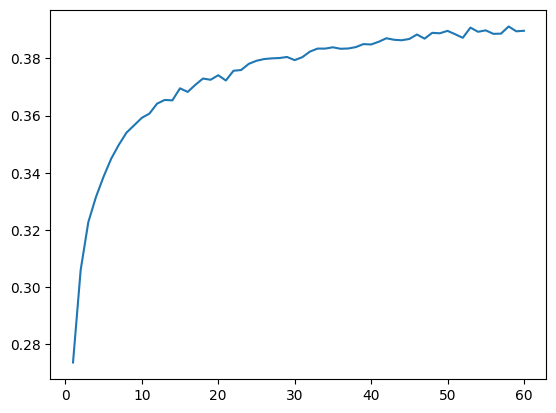

In [ ]:
import seaborn as sns
sns.lineplot(x=list(range(1, EPOCHS + 1)), y=model_accuracy)

In [ ]:
print('The best model is model{:02d}.pth\nAccuracy = {:.4f}'.format(model_accuracy.index(max(model_accuracy)) + 1, max(model_accuracy)))

The best model is model58.pth
Accuracy = 0.3912
